# SET UP

In [9]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error



In [10]:
# Configurations
pd.set_option('display.max_columns', None)

In [11]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [12]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [13]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 100 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles']]
    


In [14]:
# Initialize empty columns of calculations into dataframes

'''
for x in years:
    df = data[x]
    df['xAtt'] = np.nan
    df['xCmp'] = 
'''

"\nfor x in years:\n    df = data[x]\n    df['xAtt'] = np.nan\n    df['xCmp'] = \n"

In [52]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


# CALCULATIONS

TODO:
- [ ] Calculate league averages
- [ ] Calculate OL factors
- [ ] See if we can weigh xCmp
- [ ] Evaluate differences between xCmp and actual completions

In [18]:
# xAtt = pass attempts - throwaways - spikes
# This discounts pass attempts where no receiver was intentionally targeted
#
# NOTE: It is possible we may not want to subtract throwaways since it doesn't 
# account if there was a receiver open but the QB could not make the read

def xAtt(row):
    return row['pass_att'] - row['pass_spikes']

In [21]:
# xCmp = OnTgt throws - Bad throws + Drops
# This adds up pass attempts that where good enough to be completions (i.e. OnTgt throws) and drops that should've been caught. 
# It also subtracts pass attempts that are typically not completed  (i.e. Bad throws). These all add up to what the QB's total 
# number of completions should have been based on these stats.
#
# NOTE: the definition of "OnTgt" and "bad" throws is subjective. According
# to PFR, "bad" throws are passes that cannot be caught with "normal" effort, although
# this doesn't necessarily mean the pass is uncatchable. Similarly, "OnTgt" is not 
# specifically defined either.

def xCmp(row):
    return row['pass_on_target'] - row['pass_poor_throws'] + row['pass_drops']

In [22]:
# xCmp% = xCmp/xAtt

def xCmpPct(row):
    return float(row['xCmp']/row['xAtt']) * 100

In [23]:
# basic cmp%, i.e. cmp% = cmp/att

def cmpPct(row):
    return float(row['pass_cmp']/row['pass_att']) * 100

In [24]:
# cmpDiff = xCmp - Cmp

def cmpDiff(row):
    return row['xCmp'] - row['pass_cmp']

In [25]:
# cmpPctDiff = xCmp% - CmpPct

def cmpPctDiff(row):
    return float(row['xCmpPct']) - float(row['cmpPct'])

In [26]:
# Add in calculations into dataframes

for x in years:
    df = data[x]
    df['xAtt'] = df.apply(xAtt, axis=1)
    df['xCmp'] = df.apply(xCmp, axis=1)
    df['xCmpPct'] = df.apply(xCmpPct, axis=1)
    df['cmpPct'] = df.apply(cmpPct, axis=1)
    df['cmpDiff'] = df.apply(cmpDiff, axis=1)
    df['cmpPctDiff'] = df.apply(cmpPctDiff, axis=1)

# FITTING MODELS

In [68]:
data_total = pd.DataFrame()

for x in years:
    df = data[x]
    df['Season'] = "20" + str(x)
    data_total = pd.concat([data_total, df], axis=0)

Index(['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att',
       'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 'pass_drops',
       'pass_poor_throws', 'pass_on_target', 'pocket_time', 'pass_blitzed',
       'pass_hurried', 'pass_hits', 'pass_pressured', 'rush_scrambles',
       'Season', 'xAtt', 'xCmp', 'xCmpPct', 'cmpPct', 'cmpDiff', 'cmpPctDiff'],
      dtype='object')


In [29]:
# Create X and y

X = data_total[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops', 'xAtt']]
y = data_total[['pass_cmp']]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
xCmpLinRegModel = LinearRegression()

xCmpLinRegModel.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = xCmpLinRegModel.predict(X_test)

In [35]:
print(f"Intercept: {xCmpLinRegModel.intercept_}")
print(f"Coefficients: {xCmpLinRegModel.coef_}")

Intercept: [-6.26482911]
Coefficients: [[ 0.007313   -0.24328416  0.70941388 -0.90911175  0.22817045]]


In [36]:
# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

R²: 0.9924091064014615
Mean Squared Error (MSE): 53.348690414565894
Root Mean Squared Error (RMSE): 7.304018785200781


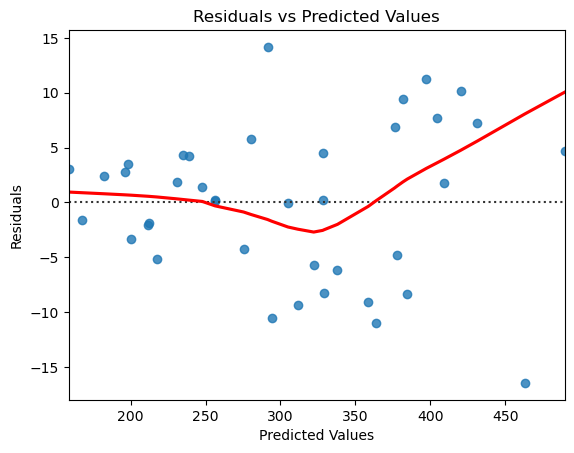

In [39]:

# Example data (assuming 'X' is the independent variable and 'y' is the dependent variable)
residuals = y_test - y_pred

# Residual plot for checking linearity assumption
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show() # No clear pattern so probably didn't overfit

In [84]:
data_total['xCmpModel'] = xCmpLinRegModel.predict(X)

data_total['xCmpPctModel'] = (data_total['xCmpModel']/data_total['xAtt']) * 100

data_total['xCmpPctModelDiff'] = (data_total['xCmpPctModel'] - data_total['cmpPct'])

# EXPORTING NEW DATAFRAMES

In [33]:
# Export dfs to CSVs

for x in years:
    df = data[x]
    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)

# CREATING VISUALS

In [47]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


### Tests

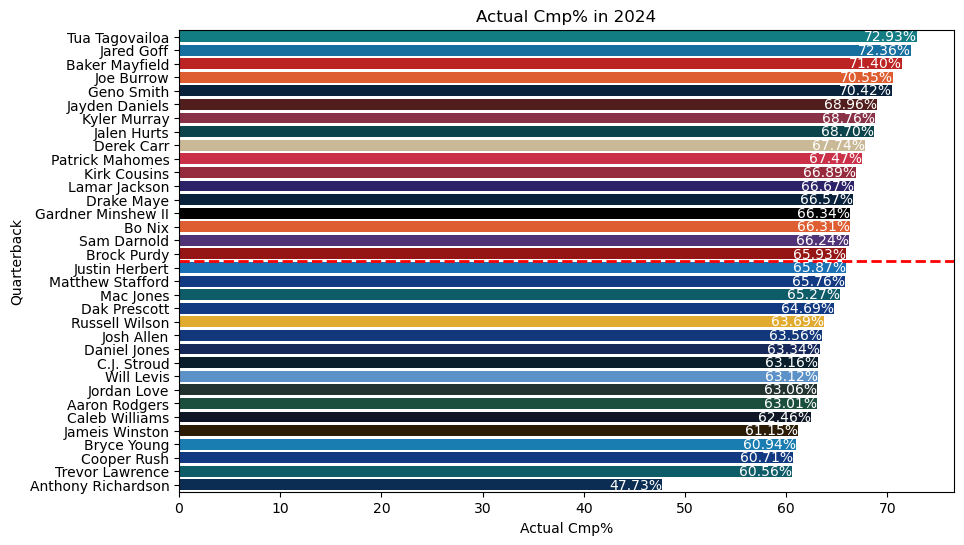

In [75]:
# Plot 2024 data as a test

cmp24 = statGrapher(data[24], 'cmpPct', 'Actual Cmp%')

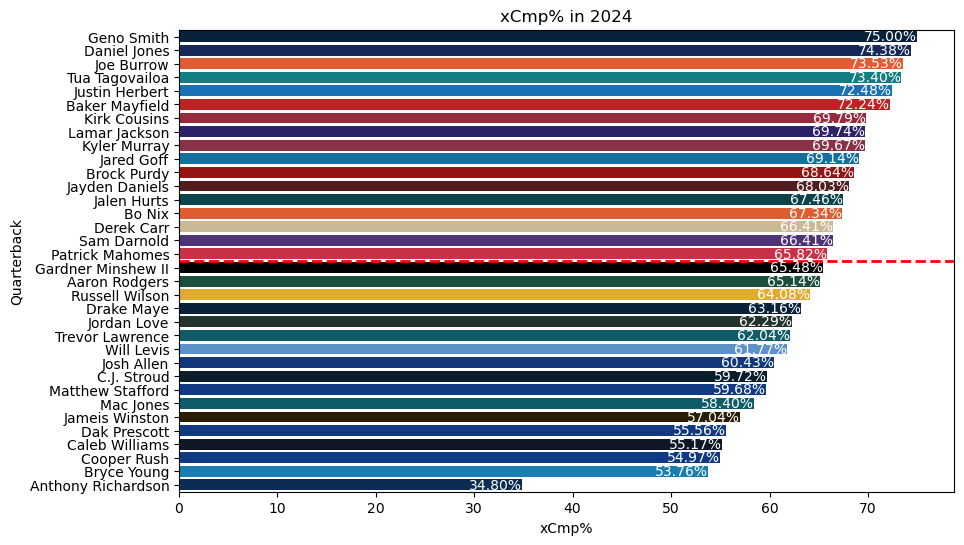

In [115]:
# 2024 xCmp%

xCmp24 = statGrapher(data[24], 'xCmpPct', 'xCmp%')

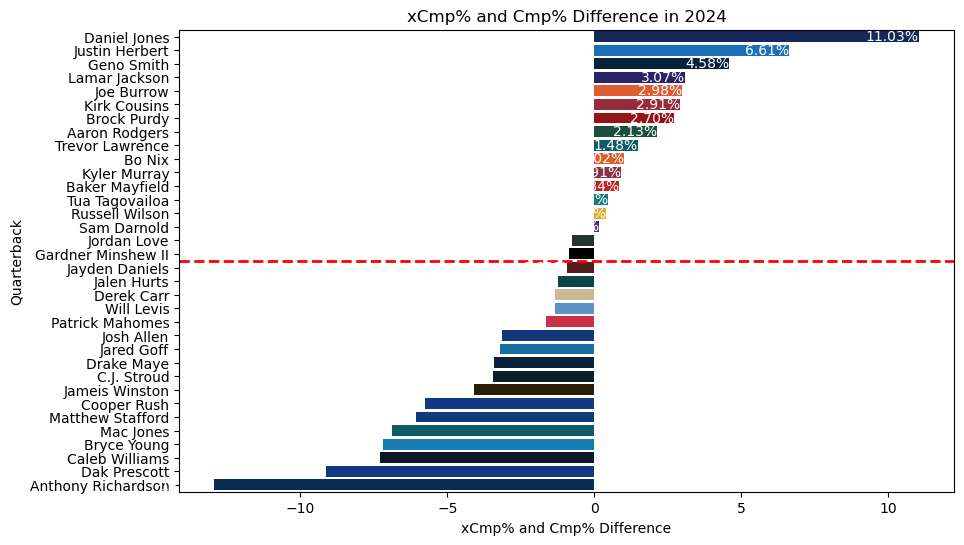

In [112]:
cmpDiff24 = statGrapher(data[24], 'cmpPctDiff', 'xCmp% and Cmp% Difference') 

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

### Visualize Model

In [88]:
data24 = data_total[data_total['Season'] == "2024"]

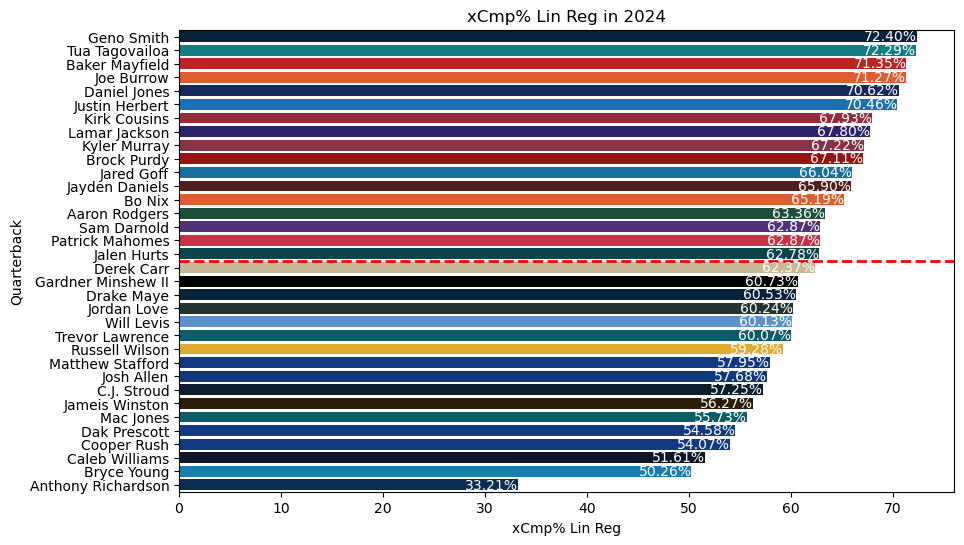

In [89]:

xCmp24LinReg = statGrapher(data24, 'xCmpPctModel', 'xCmp% Lin Reg')

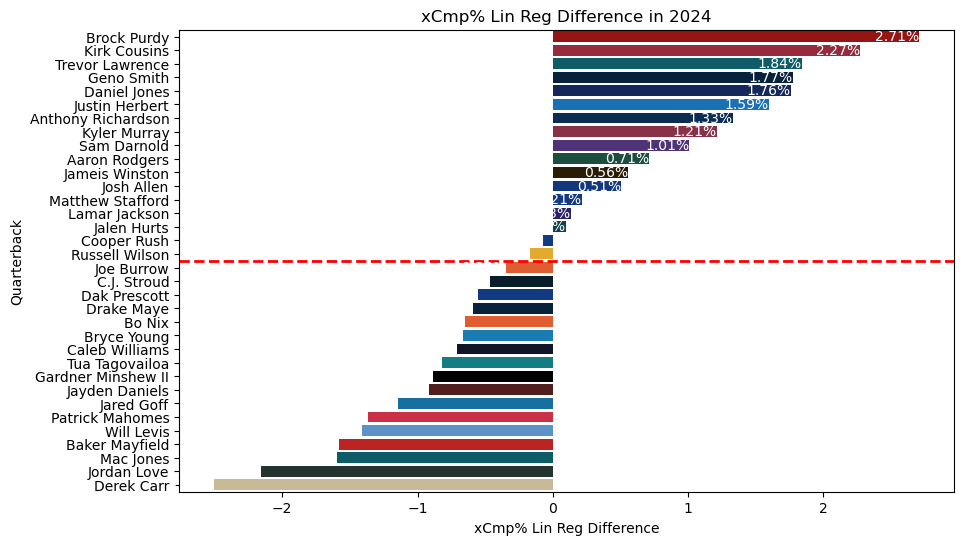

In [90]:
# 2024 xCmp% based on model

xCmp24LinRegPctDiff = statGrapher(data24, 'xCmpPctModelDiff', 'xCmp% Lin Reg Difference')

In [79]:
data24.head()

0    False
1    False
2    False
3    False
4    False
Name: Season, dtype: bool